# FF5 Factor Loadings per Equity

This notebook computes per-equity factor loadings by regressing daily excess returns on the five Fama-French factors (MKT-RF, SMB, HML, RMW, CMA). It also reports fit quality metrics (R², adj-R², alpha t-stat, F-stat, autocorrelation, and heteroskedasticity tests).
 

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import warnings


fama = pd.read_csv('fac_returns.csv', index_col=0)
fama

,HML,SMB,RMW,CMA,MKT-RF
date,,,,,
2024-06-26,0.000694,0.004540,-8.383000e-03,0.013904,-0.003496
2024-06-27,-0.000630,0.006910,-6.523864e-03,-0.010127,0.001909
2024-06-28,0.014333,0.011602,-8.516252e-03,0.000579,-0.002398
2024-07-01,-0.007871,-0.013738,9.867638e-03,-0.001526,0.002964
2024-07-02,-0.002311,-0.005201,3.004007e-03,-0.007228,0.006398
...,...,...,...,...,...
2024-12-24,-0.002971,-0.000769,1.663881e-04,-0.003638,0.010715
2024-12-26,0.002641,0.011138,-4.885561e-07,0.004604,0.000183
2024-12-27,0.007677,-0.004887,7.780140e-04,0.001505,-0.011341


In [3]:
all_tickers = pd.read_csv('All_Stock_Tickers.csv', index_col=0)
all_tickers = all_tickers[all_tickers.active == True]
all_tickers = all_tickers[all_tickers.locale == 'us']
etfs = all_tickers[all_tickers.type == 'ETF'].ticker.unique().tolist()
print(len(etfs))
# Create a properly formatted string for the SQL IN clause
etf_list_str = "(" + ",".join([f"'{ticker}'" for ticker in etfs]) + ")"

4285


In [4]:
from clickhouse_connect import get_client

client = get_client()
df = client.query_df(f"""
SELECT
    ticker,
    toDate(fromUnixTimestamp64Nano(window_start)) as date,
    close,
    FROM s3('https://files.polygon.io/flatfiles/us_stocks_sip/day_aggs_v1/2024/*/*.csv.gz')
WHERE ticker IN {etf_list_str} AND date >= '2024-06-25'
SETTINGS max_threads=16, max_threads=16
""")
import numpy as np
# Pivot the DataFrame to have dates as rows, tickers as columns, and close prices as values
df_pivoted = df.pivot(index='date', columns='ticker', values='close')
rets = np.log(df_pivoted).diff()[1:].fillna(0).reindex(fama.index)
rets

ticker,AAA,AAAU,AADR,AAPB,AAPD,AAPR,AAPU,AAPX,AAPY,AAXJ,...,ZOCT,ZROZ,ZSB,ZSC,ZSEP,ZTAX,ZTEN,ZTRE,ZTWO,ZVOL
date,,,,,,,,,,,,,,,,,,,,,
2024-06-26,0.000795,-0.008973,-0.004029,0.037637,-0.018692,0.000000,0.037556,0.036612,-0.006757,-0.001251,...,0.000000,-0.019528,0.002053,-0.007137,0.000000,0.003987,-0.005536,-0.001282,-0.000400,0.000000
2024-06-27,0.001191,0.011149,-0.002911,0.008048,-0.004449,0.002375,0.008950,0.007557,0.002417,-0.000139,...,0.000000,0.005434,-0.001135,-0.004645,0.000000,-0.000526,0.002145,0.000981,0.000597,0.000000
2024-06-28,-0.006701,0.000217,0.002588,-0.033375,0.017680,0.000000,-0.033523,-0.032604,0.000174,0.001669,...,0.000000,-0.031591,-0.000233,0.001269,0.000000,-0.008487,-0.004732,-0.000477,0.000382,0.000000
2024-07-01,0.000132,0.002605,-0.005832,0.056764,-0.030583,0.000000,0.056134,0.054939,0.005640,0.002359,...,0.000000,-0.036343,0.001368,-0.010411,0.000000,-0.020512,-0.010793,-0.004941,-0.004003,0.000000
2024-07-02,0.000599,-0.000217,-0.002114,0.033006,-0.016510,0.000395,0.031440,0.033058,0.011567,0.005529,...,0.000000,0.011670,0.004773,0.005750,0.000000,-0.001583,0.005301,0.001707,0.000954,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.000595,0.001936,0.007650,0.021083,-0.010077,0.003809,0.020401,-0.161225,-0.055807,0.004087,...,0.001777,0.004428,0.004144,0.004609,0.002145,0.005771,0.001812,0.000918,0.000703,0.020619
2024-12-26,-0.004774,0.006938,-0.000429,0.007758,-0.003382,0.000162,0.007946,0.006084,0.003969,-0.003405,...,0.000789,0.000428,0.003378,0.004801,0.000596,-0.040149,0.001247,0.000582,0.000389,-0.006141
2024-12-27,-0.000998,-0.006938,-0.006575,-0.027706,0.013459,-0.001322,-0.028348,-0.028716,-0.009091,-0.004238,...,-0.001567,-0.014205,-0.027732,-0.021360,-0.001193,0.015379,-0.003531,-0.000407,0.000099,-0.021272


In [5]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from tqdm import tqdm

# Prepare factor matrix X and response Y per ticker
FACTOR_COLS = [c for c in ['MKT-RF','SMB','HML','RMW','CMA'] if c in fama.columns]
X_all = fama[FACTOR_COLS].copy()
X_all = sm.add_constant(X_all)  # intercept = alpha

results = []

for ticker in tqdm(etfs):
    try:
        if ticker not in rets.columns:
            #print(f"Ticker {ticker} not in rets.columns")
            continue
        y = rets[ticker]
        if y is None:
            continue
        df = pd.concat([y, X_all], axis=1, join='inner').dropna()
        if df.empty:
            continue
        y_aligned = df[ticker]
        X = df[ ['const'] + FACTOR_COLS ]
        # OLS regression
        model = sm.OLS(y_aligned.values, X.values)
        res = model.fit()

        # Residual diagnostics
        resid = y_aligned.values - res.predict(X.values)
        
        # Ljung-Box test for serial correlation
        try:
            lb_result = acorr_ljungbox(resid, lags=[10], return_df=False)
            if isinstance(lb_result, tuple) and len(lb_result) >= 2:
                lb_stat = float(lb_result[0]) if hasattr(lb_result[0], '__iter__') else float(lb_result[0])
                lb_p = float(lb_result[1]) if hasattr(lb_result[1], '__iter__') else float(lb_result[1])
                # Handle array-like results
                if hasattr(lb_stat, '__iter__') and not isinstance(lb_stat, str):
                    lb_stat = float(lb_stat[0])
                if hasattr(lb_p, '__iter__') and not isinstance(lb_p, str):
                    lb_p = float(lb_p[0])
            else:
                lb_stat, lb_p = np.nan, np.nan
        except Exception:
            lb_stat, lb_p = np.nan, np.nan

        # Heteroskedasticity (Breusch-Pagan)
        try:
            bp_stat, bp_p, _, _ = het_breuschpagan(resid, X.values)
        except Exception:
            bp_stat, bp_p = np.nan, np.nan

        row = {
            'ticker': ticker,
            'n_obs': int(len(df)),
            'alpha': float(res.params[0]) if res.params.size else np.nan,
            'alpha_t': float(res.tvalues[0]) if res.tvalues.size else np.nan,
            'r2': float(res.rsquared),
            'adj_r2': float(res.rsquared_adj),
            'f_stat': float(res.fvalue) if res.fvalue is not None else np.nan,
            'f_p': float(res.f_pvalue) if res.f_pvalue is not None else np.nan,
            'lb_stat_10': lb_stat,
            'lb_p_10': lb_p,
            'bp_stat': float(bp_stat),
            'bp_p': float(bp_p),
        }
        # factor betas
        for i, name in enumerate(FACTOR_COLS, start=1):
            row[f'beta_{name}'] = float(res.params[i]) if res.params.size>i else np.nan
            row[f't_{name}'] = float(res.tvalues[i]) if res.tvalues.size>i else np.nan

        results.append(row)
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

loadings_df = pd.DataFrame(results).set_index('ticker').sort_values('adj_r2', ascending=False)
print(f"Computed loadings for {len(loadings_df)} tickers")
loadings_df.head()


 82%|████████▏ | 3533/4285 [00:03<00:00, 1131.54it/s]

Error processing ticker SMB: only length-1 arrays can be converted to Python scalars


100%|██████████| 4285/4285 [00:03<00:00, 1098.32it/s]

Computed loadings for 3539 tickers


,n_obs,alpha,alpha_t,r2,adj_r2,f_stat,f_p,lb_stat_10,lb_p_10,bp_stat,...,beta_MKT-RF,t_MKT-RF,beta_SMB,t_SMB,beta_HML,t_HML,beta_RMW,t_RMW,beta_CMA,t_CMA
ticker,,,,,,,,,,,,,,,,,,,,,
VTWO,131,-0.000476,-3.740951,0.990067,0.989670,2491.962837,2.472442e-123,NaN,NaN,7.228383,...,0.970757,53.851374,0.846770,40.620560,0.041103,2.188639,0.005720,0.237698,-0.046287,-2.968612
UWM,131,-0.001356,-5.327209,0.990026,0.989627,2481.606781,3.198981e-123,NaN,NaN,10.617624,...,1.929632,53.476143,1.682496,40.321232,0.065843,1.751519,-0.025498,-0.529347,-0.090971,-2.914740
IWM,131,-0.000467,-3.615959,0.989899,0.989495,2449.957515,7.076735e-123,NaN,NaN,10.547802,...,0.974306,53.236825,0.850452,40.184671,0.038452,2.016783,-0.003975,-0.162726,-0.045464,-2.872040
TNA,131,-0.002334,-5.955513,0.989489,0.989069,2353.507882,8.482320e-122,NaN,NaN,13.609273,...,2.912696,52.435423,2.499789,38.915922,0.088131,1.522918,-0.045718,-0.616556,-0.139526,-2.903995
URTY,131,-0.002370,-5.930759,0.989097,0.988661,2267.943003,8.369875e-121,NaN,NaN,14.298963,...,2.928497,51.699015,2.483446,37.912854,0.083698,1.418308,-0.058606,-0.775059,-0.140283,-2.863219


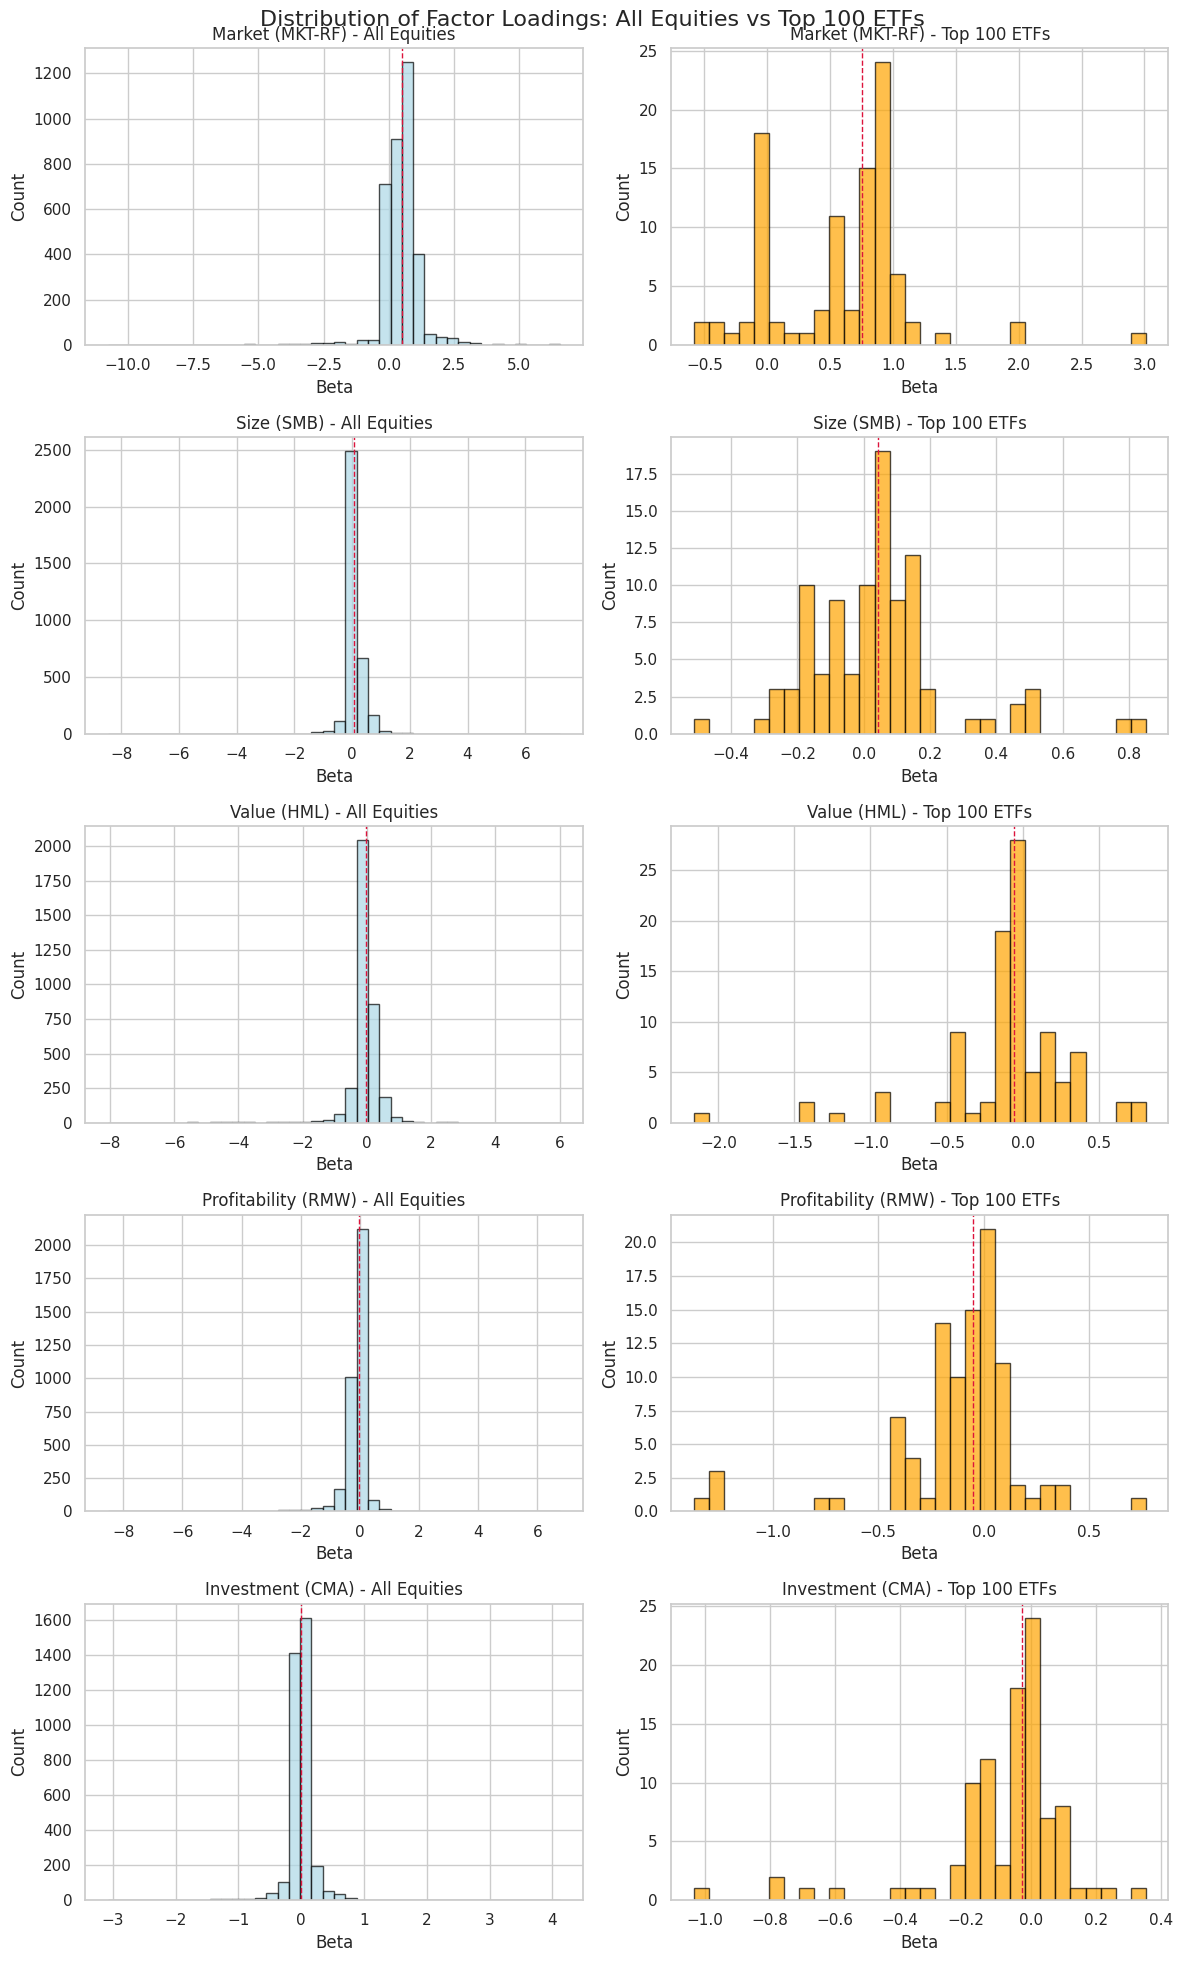

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

top_100_etfs = pd.read_csv('top_100_etfs.csv')
top_100_etfs_list = top_100_etfs['Symbol'].tolist()

beta_cols = [c for c in loadings_df.columns if c.startswith('beta_')]
long_names = {
    'beta_MKT-RF': 'Market (MKT-RF)',
    'beta_SMB': 'Size (SMB)',
    'beta_HML': 'Value (HML)',
    'beta_RMW': 'Profitability (RMW)',
    'beta_CMA': 'Investment (CMA)'
}
factors = list(long_names.keys())

# Create 5x2 subplot matrix
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i, factor in enumerate(factors):
    # Left column: All Equities
    ax_left = axes[i*2]
    all_betas = loadings_df[factor].dropna()
    ax_left.hist(all_betas, bins=40, alpha=0.7, color='lightblue', edgecolor='black')
    ax_left.axvline(all_betas.median(), color='crimson', linestyle='--', linewidth=1)
    ax_left.set_title(f'{long_names[factor]} - All Equities')
    ax_left.set_xlabel('Beta')
    ax_left.set_ylabel('Count')
    
    # Right column: Top 100 ETFs
    ax_right = axes[i*2 + 1]
    top_100_betas = loadings_df.loc[loadings_df.index.isin(top_100_etfs_list), factor].dropna()
    if not top_100_betas.empty:
        ax_right.hist(top_100_betas, bins=30, alpha=0.7, color='orange', edgecolor='black')
        ax_right.axvline(top_100_betas.median(), color='crimson', linestyle='--', linewidth=1)
    ax_right.set_title(f'{long_names[factor]} - Top 100 ETFs')
    ax_right.set_xlabel('Beta')
    ax_right.set_ylabel('Count')

plt.suptitle('Distribution of Factor Loadings: All Equities vs Top 100 ETFs', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

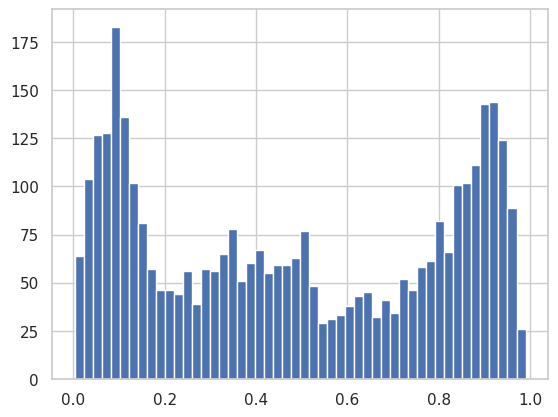

In [10]:
# from misc_helpers.plot_utils import setup_plotting
# setup_plotting()
import matplotlib.pyplot as plt
plt.hist(loadings_df['r2'], bins=50)
plt.show()


100%|██████████| 3540/3540 [00:04<00:00, 832.99it/s]


Fama-French 5-Factor Model - Cross-Sectional Summary:

R-squared Statistics:
  Mean: 0.4839
  Median: 0.4586
  Std: 0.3224
  Min: 0.0031
  Max: 0.9901

Alpha (Intercept) Statistics:
  Mean: -0.000197
  Median: -0.000108
  Std: 0.001661

Beta Statistics:
  MKT-RF: Mean=0.4704, Std=0.8401
  SMB: Mean=0.0972, Std=0.4346
  HML: Mean=-0.0474, Std=0.4920
  RMW: Mean=-0.1108, Std=0.4878
  CMA: Mean=-0.0074, Std=0.2768


/tmp/ipykernel_3013/531104440.py:150: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(beta_data, labels=beta_labels, patch_artist=True)


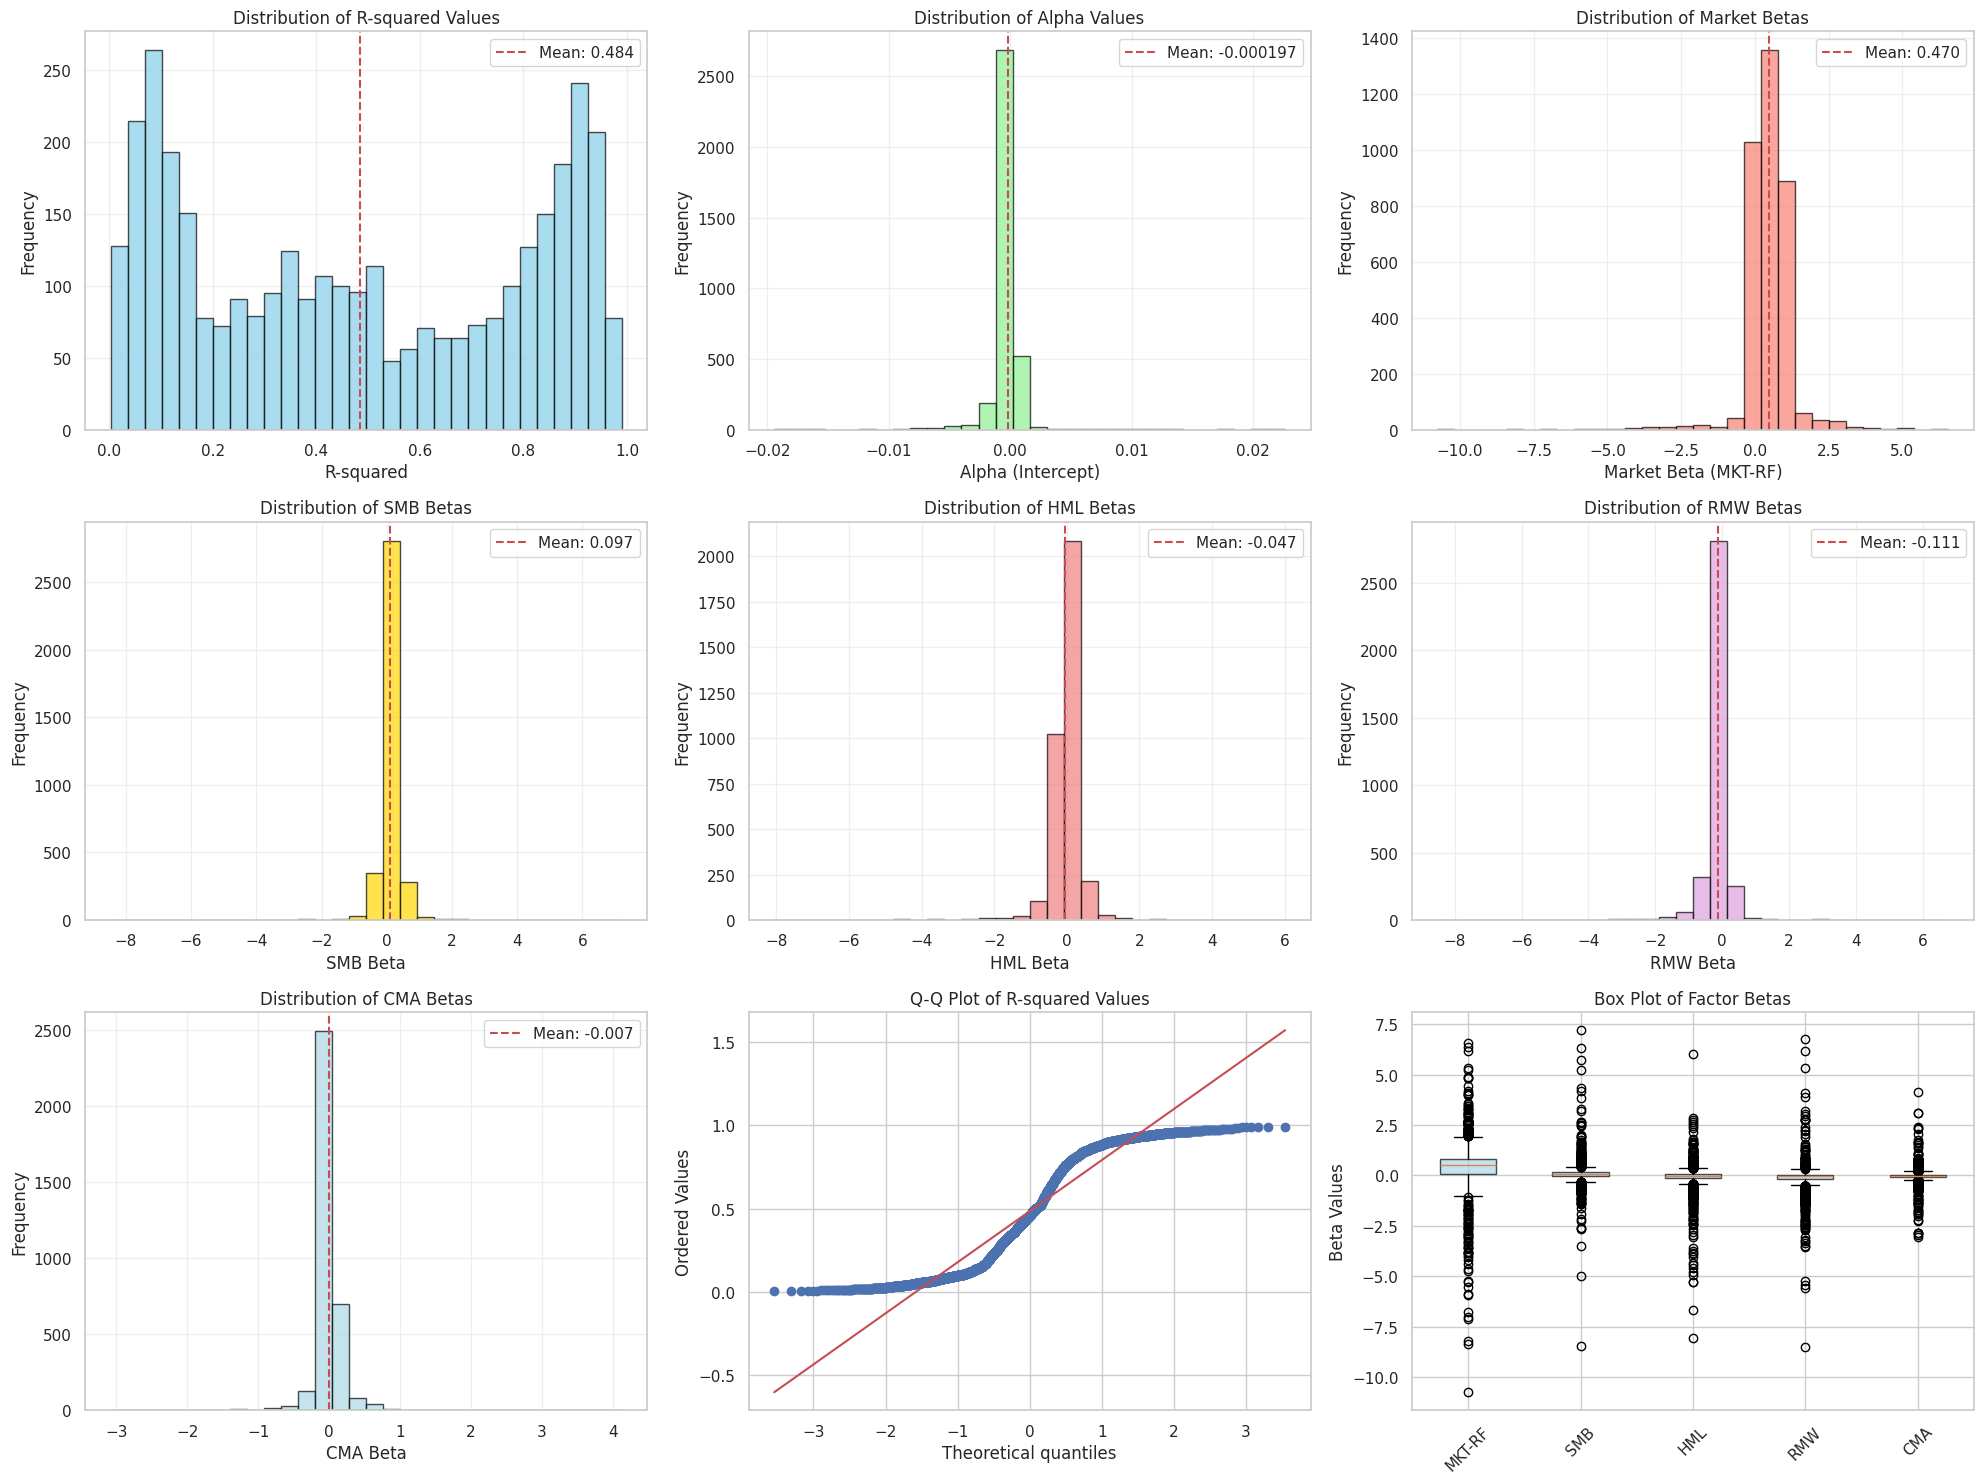


Correlation Matrix of Betas:
        MKT-RF    SMB    HML    RMW    CMA
MKT-RF   1.000 -0.287  0.298 -0.529 -0.228
SMB     -0.287  1.000 -0.196  0.499 -0.010
HML      0.298 -0.196  1.000  0.197  0.136
RMW     -0.529  0.499  0.197  1.000 -0.279
CMA     -0.228 -0.010  0.136 -0.279  1.000

Top 10 Stocks by R-squared:
     ticker  r_squared   alpha  mkt_beta
3331   VTWO     0.9901 -0.0005    0.9708
3227    UWM     0.9900 -0.0014    1.9296
1687    IWM     0.9899 -0.0005    0.9743
3070    TNA     0.9895 -0.0023    2.9127
3185   URTY     0.9891 -0.0024    2.9285
3132    TZA     0.9881  0.0006   -2.9346
2657   RSSL     0.9841 -0.0005    1.0301
2936   SRTY     0.9831  0.0003   -2.9249
2391   PRFZ     0.9801 -0.0003    0.9278
204    BBSC     0.9799 -0.0003    0.9824

Bottom 10 Stocks by R-squared:
     ticker  r_squared   alpha  mkt_beta
2725   SCUS     0.0031  0.0000   -0.0008
678    DRAG     0.0053 -0.0014   -0.1567
2304   PCMM     0.0063  0.0000    0.0061
1049   FINT     0.0068 -0.0000    0.

In [16]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Prepare data for regression - loop through all stocks
common_dates = fama.index.intersection(rets.index)
X_base = fama.loc[common_dates, ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']]

# Initialize lists to store results
results = []
r_squareds = []
alphas = []
betas = {'const': [], 'MKT-RF': [], 'SMB': [], 'HML': [], 'RMW': [], 'CMA': []}

# Loop through all stocks in returns
for ticker in tqdm(rets.columns):
    y = rets.loc[common_dates, ticker]
    
    # Add constant for intercept
    X = sm.add_constant(X_base)
    
    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Store results
    results.append({
        'ticker': ticker,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'alpha': model.params['const'],
        'mkt_beta': model.params['MKT-RF'],
        'smb_beta': model.params['SMB'],
        'hml_beta': model.params['HML'],
        'rmw_beta': model.params['RMW'],
        'cma_beta': model.params['CMA']
    })
    
    # Store for distributions
    r_squareds.append(model.rsquared)
    alphas.append(model.params['const'])
    for factor in ['const', 'MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']:
        betas[factor].append(model.params[factor])

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("Fama-French 5-Factor Model - Cross-Sectional Summary:")
print(f"\nR-squared Statistics:")
print(f"  Mean: {np.mean(r_squareds):.4f}")
print(f"  Median: {np.median(r_squareds):.4f}")
print(f"  Std: {np.std(r_squareds):.4f}")
print(f"  Min: {np.min(r_squareds):.4f}")
print(f"  Max: {np.max(r_squareds):.4f}")

print(f"\nAlpha (Intercept) Statistics:")
print(f"  Mean: {np.mean(alphas):.6f}")
print(f"  Median: {np.median(alphas):.6f}")
print(f"  Std: {np.std(alphas):.6f}")

print(f"\nBeta Statistics:")
for factor, beta_vals in betas.items():
    if factor != 'const':
        print(f"  {factor}: Mean={np.mean(beta_vals):.4f}, Std={np.std(beta_vals):.4f}")

# Create comprehensive plots
fig = plt.figure(figsize=(20, 15))

# 1. R-squared distribution
ax1 = plt.subplot(3, 3, 1)
plt.hist(r_squareds, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(np.mean(r_squareds), color='r', linestyle='--', label=f'Mean: {np.mean(r_squareds):.3f}')
plt.xlabel('R-squared')
plt.ylabel('Frequency')
plt.title('Distribution of R-squared Values')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Alpha distribution
ax2 = plt.subplot(3, 3, 2)
plt.hist(alphas, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
plt.axvline(np.mean(alphas), color='r', linestyle='--', label=f'Mean: {np.mean(alphas):.6f}')
plt.xlabel('Alpha (Intercept)')
plt.ylabel('Frequency')
plt.title('Distribution of Alpha Values')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Market Beta distribution
ax3 = plt.subplot(3, 3, 3)
plt.hist(betas['MKT-RF'], bins=30, alpha=0.7, edgecolor='black', color='salmon')
plt.axvline(np.mean(betas['MKT-RF']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["MKT-RF"]):.3f}')
plt.xlabel('Market Beta (MKT-RF)')
plt.ylabel('Frequency')
plt.title('Distribution of Market Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. SMB Beta distribution
ax4 = plt.subplot(3, 3, 4)
plt.hist(betas['SMB'], bins=30, alpha=0.7, edgecolor='black', color='gold')
plt.axvline(np.mean(betas['SMB']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["SMB"]):.3f}')
plt.xlabel('SMB Beta')
plt.ylabel('Frequency')
plt.title('Distribution of SMB Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. HML Beta distribution
ax5 = plt.subplot(3, 3, 5)
plt.hist(betas['HML'], bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
plt.axvline(np.mean(betas['HML']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["HML"]):.3f}')
plt.xlabel('HML Beta')
plt.ylabel('Frequency')
plt.title('Distribution of HML Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. RMW Beta distribution
ax6 = plt.subplot(3, 3, 6)
plt.hist(betas['RMW'], bins=30, alpha=0.7, edgecolor='black', color='plum')
plt.axvline(np.mean(betas['RMW']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["RMW"]):.3f}')
plt.xlabel('RMW Beta')
plt.ylabel('Frequency')
plt.title('Distribution of RMW Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. CMA Beta distribution
ax7 = plt.subplot(3, 3, 7)
plt.hist(betas['CMA'], bins=30, alpha=0.7, edgecolor='black', color='lightblue')
plt.axvline(np.mean(betas['CMA']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["CMA"]):.3f}')
plt.xlabel('CMA Beta')
plt.ylabel('Frequency')
plt.title('Distribution of CMA Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Q-Q plot for R-squared (to check normality)
ax8 = plt.subplot(3, 3, 8)
stats.probplot(r_squareds, dist="norm", plot=plt)
plt.title('Q-Q Plot of R-squared Values')

# 9. Box plot of all betas
ax9 = plt.subplot(3, 3, 9)
beta_data = [betas['MKT-RF'], betas['SMB'], betas['HML'], betas['RMW'], betas['CMA']]
beta_labels = ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']
box = plt.boxplot(beta_data, labels=beta_labels, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
plt.title('Box Plot of Factor Betas')
plt.ylabel('Beta Values')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional analysis: Correlation matrix of betas
beta_df = pd.DataFrame(betas)
beta_corr = beta_df.drop('const', axis=1).corr()
print(f"\nCorrelation Matrix of Betas:")
print(beta_corr.round(3))

# Top 10 stocks by R-squared
top_r2 = results_df.nlargest(10, 'r_squared')[['ticker', 'r_squared', 'alpha', 'mkt_beta']]
print(f"\nTop 10 Stocks by R-squared:")
print(top_r2.round(4))

# Bottom 10 stocks by R-squared
bottom_r2 = results_df.nsmallest(10, 'r_squared')[['ticker', 'r_squared', 'alpha', 'mkt_beta']]
print(f"\nBottom 10 Stocks by R-squared:")
print(bottom_r2.round(4))

# Save results to DataFrame for further analysis
print(f"\nFull results saved to results_df with shape: {results_df.shape}")


Running cointegration tests on cumulative returns for all equities... (this may take a while)


Cointegration Tests:   0%|          | 0/3540 [00:00<?, ?it/s]


Cointegration Test Results (on Cumulative Returns):
Total equities tested: 3540
Cointegrated equities: 282
Percentage cointegrated: 7.97%


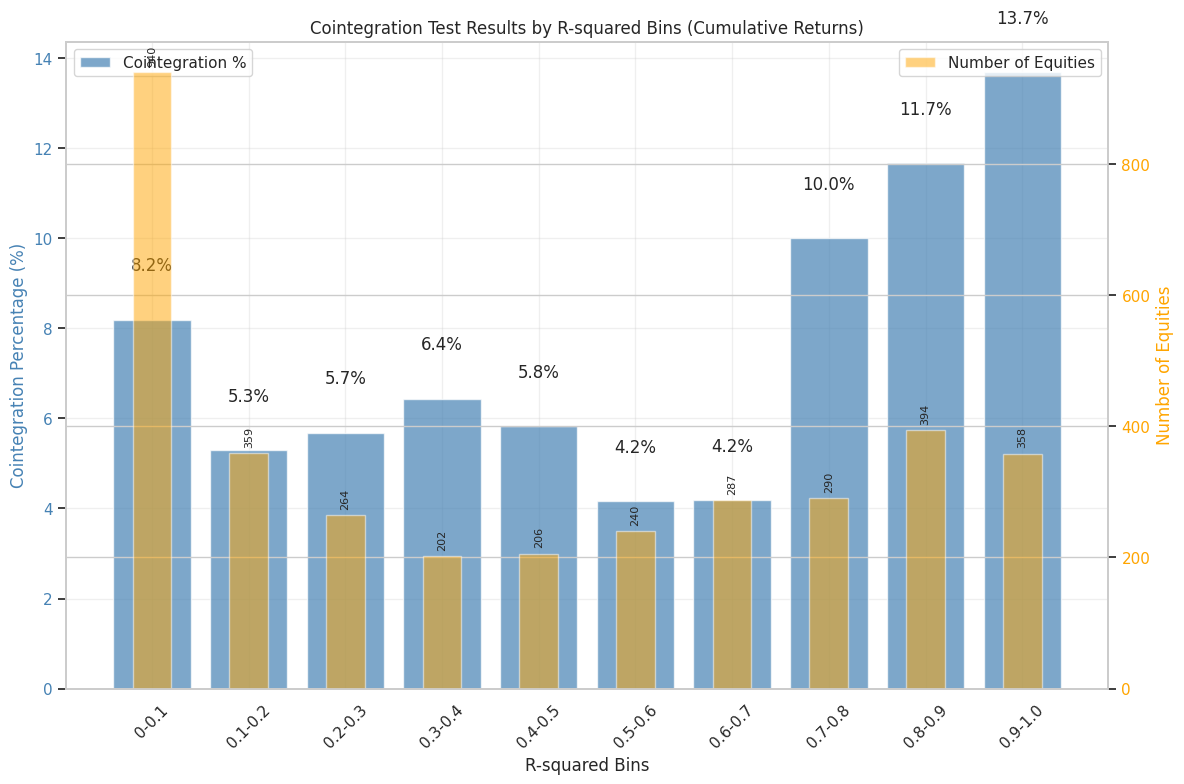


Detailed Bin Analysis:
 R2_Bin  Num_Equities  Cointegrated Percentage
  0-0.1           940            77      8.19%
0.1-0.2           359            19      5.29%
0.2-0.3           264            15      5.68%
0.3-0.4           202            13      6.44%
0.4-0.5           206            12      5.83%
0.5-0.6           240            10      4.17%
0.6-0.7           287            12      4.18%
0.7-0.8           290            29     10.00%
0.8-0.9           394            46     11.68%
0.9-1.0           358            49     13.69%

Cointegration results saved to cointegration_df with shape: (3540, 7)


In [17]:
from scipy.stats import chi2
from tqdm.auto import tqdm
import warnings
import numpy as np  # Assuming np is imported; add if not
import pandas as pd  # Assuming pd is imported; add if not
import statsmodels.api as sm  # Assuming sm is imported; add if not
import matplotlib.pyplot as plt  # Assuming plt is imported; add if not

warnings.filterwarnings('ignore')

# Compute cumulative sums (integrated returns, approximating price levels)
# Assuming rets and fac_returns are DataFrames with excess returns
cum_rets = rets.cumsum()  # Cumulative stock returns
cum_fac = fama['MKT-RF'].cumsum()  # Cumulative market returns

# Perform Engle-Granger cointegration test for each equity against market
cointegration_results = []
r2_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
              '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# Initialize counters for bin analysis
bin_cointegrated = np.zeros(len(r2_bins)-1)
bin_total = np.zeros(len(r2_bins)-1)

print("Running cointegration tests on cumulative returns for all equities... (this may take a while)")
for ticker in tqdm(rets.columns, desc="Cointegration Tests"):
    try:
        y = cum_rets.loc[common_dates, ticker].dropna()
        x = cum_fac.loc[common_dates].reindex(y.index).dropna()
        
        # Align data
        common_idx = y.index.intersection(x.index)
        if len(common_idx) < 30:  # Skip if too few observations
            continue
            
        y_aligned = y.loc[common_idx]
        x_aligned = x.loc[common_idx]
        
        # Skip if still not enough data
        if len(y_aligned) < 30:
            continue
            
        # First stage: OLS regression of cumulative stock returns on cumulative market
        X_reg = sm.add_constant(x_aligned)
        model1 = sm.OLS(y_aligned, X_reg).fit()
        residuals = model1.resid
        
        # Second stage: ADF test on residuals
        adf_result = sm.tsa.stattools.adfuller(residuals, regression='c', autolag='AIC')
        adf_stat = adf_result[0]
        p_value = adf_result[1]
        
        # Critical values for cointegration test (Engle-Granger)
        n_obs = len(residuals)
        if n_obs <= 50:
            crit_90 = -3.37
            crit_95 = -3.67
            crit_99 = -4.21
        elif n_obs <= 100:
            crit_90 = -3.27
            crit_95 = -3.57
            crit_99 = -4.11
        elif n_obs <= 250:
            crit_90 = -3.13
            crit_95 = -3.43
            crit_99 = -3.96
        else:
            crit_90 = -3.04
            crit_95 = -3.34
            crit_99 = -3.88
        
        # Determine if cointegrated (reject null of unit root)
        cointegrated = (adf_stat < crit_95)  # Using 5% significance level
        
        # Get R-squared from first stage regression (now on cumsums, so measures long-run fit)
        r_squared = model1.rsquared
        
        # Store results
        cointegration_results.append({
            'ticker': ticker,
            'r_squared': r_squared,
            'adf_stat': adf_stat,
            'adf_p_value': p_value,
            'n_obs': n_obs,
            'cointegrated': cointegrated,
            'crit_95': crit_95
        })
        
        # Update bin counters
        if not np.isnan(r_squared):
            bin_idx = np.digitize(r_squared, r2_bins) - 1
            if 0 <= bin_idx < len(bin_total):
                bin_total[bin_idx] += 1
                if cointegrated:
                    bin_cointegrated[bin_idx] += 1
                    
    except Exception as e:
        # Skip problematic tickers
        continue

# Convert to DataFrame
cointegration_df = pd.DataFrame(cointegration_results)

# Overall statistics
total_equities = len(cointegration_df)
cointegrated_count = cointegration_df['cointegrated'].sum()
cointegration_percentage = (cointegrated_count / total_equities) * 100 if total_equities > 0 else 0

print(f"\nCointegration Test Results (on Cumulative Returns):")
print(f"Total equities tested: {total_equities}")
print(f"Cointegrated equities: {cointegrated_count}")
print(f"Percentage cointegrated: {cointegration_percentage:.2f}%")

# Bin analysis
bin_percentages = []
for i in range(len(bin_total)):
    if bin_total[i] > 0:
        percentage = (bin_cointegrated[i] / bin_total[i]) * 100
    else:
        percentage = 0
    bin_percentages.append(percentage)

# Create visualization
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for cointegration percentage by R-squared bin
bars1 = ax1.bar(range(len(bin_labels)), bin_percentages, 
                color='steelblue', alpha=0.7, label='Cointegration %')
ax1.set_xlabel('R-squared Bins')
ax1.set_ylabel('Cointegration Percentage (%)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(range(len(bin_labels)))
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_title('Cointegration Test Results by R-squared Bins (Cumulative Returns)')
ax1.grid(True, alpha=0.3)

# Twin y-axis for number of equities per bin
ax2 = ax1.twinx()
bars2 = ax2.bar(range(len(bin_labels)), bin_total, 
                color='orange', alpha=0.5, width=0.4, label='Number of Equities')
ax2.set_ylabel('Number of Equities', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add value labels on bars
max_n = max(bin_total) if len(bin_total) > 0 else 1
for i, (p, n) in enumerate(zip(bin_percentages, bin_total)):
    if n > 0:
        ax1.text(i, p + 1, f'{p:.1f}%', ha='center', va='bottom')
    ax2.text(i, n + max_n * 0.01, f'{int(n)}', ha='center', va='bottom', 
             rotation=90, fontsize=8)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary table
print(f"\nDetailed Bin Analysis:")
summary_data = []
for i, label in enumerate(bin_labels):
    if bin_total[i] > 0:
        pct = bin_percentages[i]
        summary_data.append({
            'R2_Bin': label,
            'Num_Equities': int(bin_total[i]),
            'Cointegrated': int(bin_cointegrated[i]),
            'Percentage': f"{pct:.2f}%"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save results
print(f"\nCointegration results saved to cointegration_df with shape: {cointegration_df.shape}")

In [13]:
# Save outputs
out_dir = BASE_DIR
loadings_path = out_dir / 'ff5_equity_loadings.csv'

# Save with ticker as index (since it's already set as index)
loadings_df.to_csv(loadings_path, index=True)
print(f"✓ Saved loadings to {loadings_path}")

# Display a compact preview - loadings_df already has ticker as index
cols_display = ['n_obs','alpha','alpha_t','r2','adj_r2','f_stat','f_p'] + [c for c in loadings_df.columns if c.startswith('beta_')][:5]
loadings_df[cols_display].head(10)


✓ Saved loadings to /home/grego/Alphathon/fama_five_factor_model/ff5_equity_loadings.csv


,n_obs,alpha,alpha_t,r2,adj_r2,f_stat,f_p,beta_MKT-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA
ticker,,,,,,,,,,,,
PPCB,434,1.071412,0.557186,0.999827,0.999825,495699.014288,0.000000e+00,1172.981014,5658.552470,1504.766558,-1306.863858,35883.980859
NXTT,434,-0.004127,-0.860302,0.923016,0.922116,1026.315639,1.032420e-235,-1.053076,-0.017692,2.990719,-15.649860,62.873578
QQQX,434,-0.000172,-0.646734,0.781809,0.779261,306.717664,5.335284e-139,0.890488,0.001010,0.051992,0.008640,-3.420305
ASG,434,-0.000438,-1.444006,0.761908,0.759126,273.924768,6.652690e-131,0.994167,-0.000348,0.078855,0.006489,-0.546628
ETG,434,0.000106,0.405231,0.757025,0.754186,266.699532,5.077134e-129,0.893986,-0.002412,0.148894,-0.009015,4.342995
NIE,434,0.000040,0.157417,0.751110,0.748202,258.326813,8.629602e-127,0.850001,-0.001768,0.091834,-0.006441,3.076260
NBXG,434,0.000156,0.472724,0.741938,0.738923,246.102858,1.956304e-123,0.966415,0.002714,0.155420,0.005678,-7.743843
BXMX,434,-0.000033,-0.145293,0.740430,0.737398,244.176516,6.783131e-123,0.755916,-0.002258,0.149345,-0.009134,3.818188
STK,434,-0.000269,-0.793040,0.738579,0.735525,241.840778,3.093281e-122,0.965485,0.002587,0.106895,-0.003836,-8.821779


### ETFs


In [18]:
# Load ETF universe
import pandas as pd
from pathlib import Path

etf_csv = Path('All_Stock_Tickers.csv')
if not etf_csv.exists():
    raise FileNotFoundError(str(etf_csv))

df_all = pd.read_csv(etf_csv)
# Expect columns like: ticker, type, active, locale, primary_exchange (or similar)
# Normalize column names
cols = {c.lower(): c for c in df_all.columns}

def col(name):
    return cols.get(name, name)

# Filter ETFs: type='ETF', active=True, locale='us'
mask = (
    df_all[col('type')].astype(str).str.upper().eq('ETF') &
    df_all[col('active')].astype(str).str.lower().isin(['true','1','t','yes']) &
    df_all[col('locale')].astype(str).str.lower().eq('us')
)

df_etf = df_all.loc[mask].copy()
# Standardize primary exchange column name
if 'primary_exchange' in [c.lower() for c in df_etf.columns]:
    pe_col = [c for c in df_etf.columns if c.lower()=='primary_exchange'][0]
else:
    # try common variants
    for cand in ['primaryExchange','primary_exchange','exchange','primary_exchange_code']:
        if cand in df_etf.columns:
            pe_col = cand
            break
    else:
        pe_col = None

print(f"Total rows: {len(df_all)}  |  ETFs (US, active): {len(df_etf)}")
if pe_col:
    print(f"Exchanges (top 10):\n{df_etf[pe_col].value_counts().head(10)}")

etf_tickers = df_etf[col('ticker')].dropna().astype(str).str.upper().unique().tolist()
print(f"Unique ETF tickers: {len(etf_tickers)}")



Total rows: 11765  |  ETFs (US, active): 4285
Exchanges (top 10):
primary_exchange
ARCX    2205
BATS    1030
XNAS     992
XNYS      58
Name: count, dtype: int64
Unique ETF tickers: 4285


In [26]:
# Compute ETF loadings and diagnostics by exchange
import yfinance as yf
import statsmodels.api as sm
import numpy as np

# Limit to a manageable number if huge
MAX_ETF = 400
etf_list = etf_tickers[:MAX_ETF]
print(f"Downloading prices for {len(etf_list)} ETFs...")

# Align to factor date range
dates = fama.index
start_date = dates.min()#.strftime('%Y-%m-%d')
end_date = dates.max()#.strftime('%Y-%m-%d')

px_etf = yf.download(etf_list, start=start_date, end=end_date, auto_adjust=True, progress=True, threads=True)["Close"]
if isinstance(px_etf, pd.Series):
    px_etf = px_etf.to_frame(name=etf_list[0])
px_etf = px_etf.reindex(dates).ffill()
ret_etf = px_etf.pct_change().loc[dates].dropna(how='all')

FACTOR_COLS = [c for c in ['MKT-RF','SMB','HML','RMW','CMA'] if c in fama.columns]
X_all = sm.add_constant(fama[FACTOR_COLS])

rows = []
for tkr in ret_etf.columns:
    try:
        y = rets[tkr]
        df = pd.concat([y, X_all], axis=1, join='inner').dropna()
        if df.empty:
            continue
        res = sm.OLS(df[tkr].values, df[['const'] + FACTOR_COLS].values).fit()
        row = {
            'ticker': tkr,
            'n_obs': int(len(df)),
            'r2': float(res.rsquared),
            'adj_r2': float(res.rsquared_adj),
        }
        for i, name in enumerate(FACTOR_COLS, start=1):
            row[f'beta_{name}'] = float(res.params[i]) if res.params.size>i else np.nan
        rows.append(row)
    except Exception as e:
        print(f"Error processing {tkr}: {e}")
        continue

etf_loadings = pd.DataFrame(rows)

# Attach exchange info
if 'pe_col' in globals() and pe_col is not None:
    exch_map = df_etf.set_index(col('ticker'))[pe_col].to_dict()
    etf_loadings['primary_exchange'] = etf_loadings['ticker'].map(exch_map)
else:
    etf_loadings['primary_exchange'] = 'unknown'

print(f"Computed ETF loadings: {len(etf_loadings)}")

# Basic diagnostics
diag = etf_loadings.groupby('primary_exchange')['adj_r2'].agg(['count','mean','median','std']).sort_values('mean', ascending=False)
diag.head(10)


[                       0%                       ]  2 of 400 completed

[*********************100%***********************]  400 of 400 completed

96 Failed downloads:
['BLST', 'AGIQ', 'AFRU', 'ARMU', 'AALG', 'BESF', 'ABLS', 'APED', 'BLGR', 'AVGW', 'AKAF', 'BEGS', 'BMNU', 'BASG', 'BENJ', 'APXM', 'APPX', 'BASV', 'ASTX', 'ABIG', 'ADBG', 'BLUC', 'AMDU', 'ANEL', 'AVUQ', 'AFIX', 'AGRW', 'ARMG', 'AIOO', 'BLUX', 'ACVT', 'BCHI', 'BCLO', 'BOED', 'AMZW', 'AMUU', 'ALLW', 'ASGM', 'ABI', 'AVGB', 'AEMS', 'APLX', 'AUSM', 'AMYY', 'ARCX', 'BNDY', 'ASMG', 'BDBT', 'ASCE', 'BCOR', 'BPI', 'BCCC', 'BLTD', 'BFJL', 'ACII', 'BOEU', 'AFOS', 'AAUS', 'ASLV', 'BCKT', 'ACEI', 'BAIG', 'AMDG', 'AVGG', 'AAAA', 'BFRE', 'ACKY', 'AAPW', 'AFSC', 'BOBP', 'BDYN', 'BFAP', 'AGEM', 'AVGU', 'AXUP', 'BINT', 'BLOX', 'ALIL', 'AGGA', 'BFRZ', 'BAGY', 'BITK', 'AIPO', 'AMDD', 'BITY', 'AZYY', 'BMAX', 'BKNU', 'BILT', 'BDVL', 'BNDS', 'BLUI', 'BKCG', 'AMDW', 'ALRG', 'BOEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-06-26 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for start

Error processing AAAA: 'AAAA'
Error processing AALG: 'AALG'
Error processing AAPW: 'AAPW'
Error processing AAUS: 'AAUS'
Error processing AAVM: 'AAVM'
Error processing ABI: 'ABI'
Error processing ABIG: 'ABIG'
Error processing ABLS: 'ABLS'
Error processing ABXB: 'ABXB'
Error processing ACEI: 'ACEI'
Error processing ACII: 'ACII'
Error processing ACKY: 'ACKY'
Error processing ACVT: 'ACVT'
Error processing ADBG: 'ADBG'
Error processing AEMS: 'AEMS'
Error processing AFOS: 'AFOS'
Error processing AFRU: 'AFRU'
Error processing AFSC: 'AFSC'
Error processing AGEM: 'AGEM'
Error processing AGGA: 'AGGA'
Error processing AGIQ: 'AGIQ'
Error processing AGRW: 'AGRW'
Error processing AIOO: 'AIOO'
Error processing AIPO: 'AIPO'
Error processing AKAF: 'AKAF'
Error processing ALIL: 'ALIL'
Error processing ALLW: 'ALLW'
Error processing ALRG: 'ALRG'
Error processing AMDD: 'AMDD'
Error processing AMDG: 'AMDG'
Error processing AMDU: 'AMDU'
Error processing AMDW: 'AMDW'
Error processing AMUU: 'AMUU'
Error proces

,count,mean,median,std
primary_exchange,,,,
BATS,83,0.505580,0.478815,0.330518
XNAS,56,0.455193,0.465987,0.280715
ARCX,161,0.445918,0.423860,0.325939
XNYS,2,0.023101,0.023101,0.009263


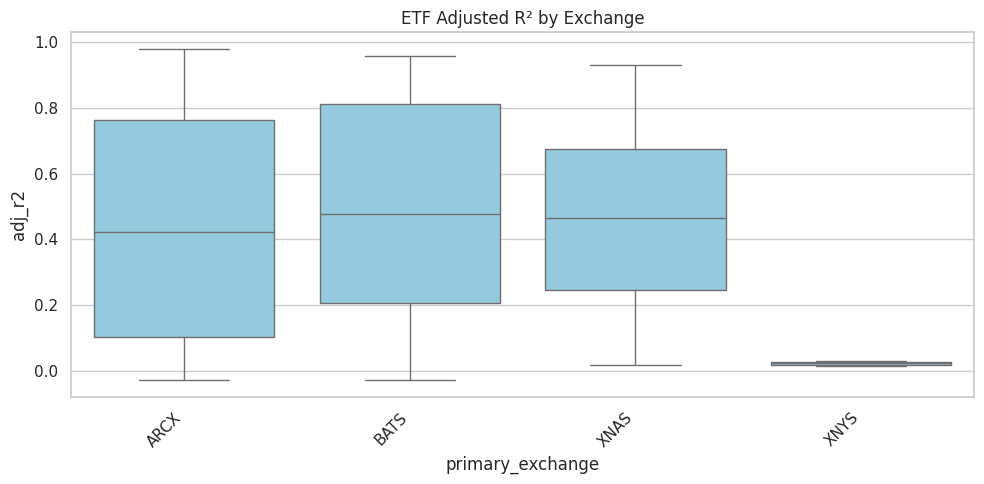

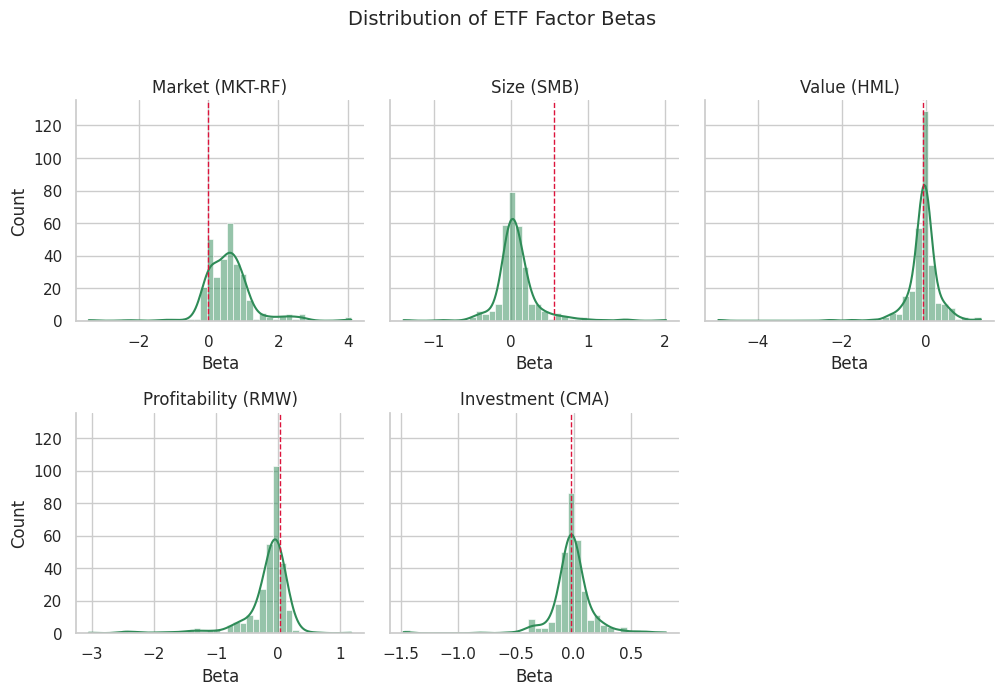

In [27]:
# ETF plots: R^2 by exchange and factor beta distributions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

if not etf_loadings.empty:
    # R^2 by exchange (boxplot)
    plt.figure(figsize=(10,5))
    top_ex = etf_loadings['primary_exchange'].value_counts().index[:10]
    sub = etf_loadings[etf_loadings['primary_exchange'].isin(top_ex)].copy()
    sns.boxplot(data=sub, x='primary_exchange', y='adj_r2', color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('ETF Adjusted R² by Exchange')
    plt.tight_layout()
    plt.show()

    # Factor loading distributions for ETFs
    beta_cols = [c for c in etf_loadings.columns if c.startswith('beta_')]
    melted = etf_loadings.melt(id_vars=['ticker','primary_exchange'], value_vars=beta_cols, var_name='factor', value_name='beta')
    name_map = {
        'beta_MKT-RF': 'Market (MKT-RF)',
        'beta_SMB': 'Size (SMB)',
        'beta_HML': 'Value (HML)',
        'beta_RMW': 'Profitability (RMW)',
        'beta_CMA': 'Investment (CMA)'
    }
    melted['factor_pretty'] = melted['factor'].map(name_map).fillna(melted['factor'])

    g = sns.FacetGrid(melted, col='factor_pretty', col_wrap=3, sharex=False, height=3.4)
    g.map_dataframe(sns.histplot, x='beta', bins=40, kde=True, color='seagreen')
    g.set_titles('{col_name}')
    for ax, (factor, subg) in zip(g.axes.flatten(), melted.groupby('factor_pretty')):
        m = subg['beta'].median()
        ax.axvline(m, color='crimson', linestyle='--', linewidth=1)
        ax.set_xlabel('Beta')
        ax.set_ylabel('Count')
    plt.suptitle('Distribution of ETF Factor Betas', y=1.02, fontsize=14)
    plt.tight_layout()
else:
    print('No ETF loadings to plot.')

